In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import mediacloud, datetime
import pandas as pd
import numpy as np
from mpv import config, mc

from bokeh.plotting import show, figure, output_file, ColumnDataSource, reset_output
from bokeh.layouts import gridplot
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

* controversy_id for 2013: 1421
* controversy_id for 2014: 1326
* controversy_id for 2015: 1394 
* controversy_id for 2016: 1408

In [ ]:
# takes a long time - 30 - 40 minutes. skip this -- it's stored in the .csv in the next section.

day = datetime.date(2013,1,1)
week = datetime.timedelta(7)

dates = []
num_stories_about_victims = []
num_stories_in_mediacloud = []

while day < datetime.date(2016, 7, 13):
    # number of stories about victims of police violence in that week
    aboutvictims = mc.storyCount("{~ topic:1421} OR {~ topic:1326} OR {~ topic:1394} OR {~ topic:1408}", 
                                 solr_filter=[mc.publish_date_query( day, day+week )])
    num_stories_about_victims.append(aboutvictims['count'])
    
    # number of total stories in mediacloud in these media sets in that week
    total = mc.storyCount("(tags_id_media:(8875027 2453107 129 8878292 8878293 8878294))",
                          solr_filter=[mc.publish_date_query( day, day+week)])
    num_stories_in_mediacloud.append(total['count'])
    
    # the first day of that week
    dates.append(day)
    
    # print progress and increment to next week
    print(day, aboutvictims, total)
    day += week

In [ ]:
storycounts = pd.DataFrame({'num_stories_about_victims':num_stories_about_victims,
                            'num_stories_in_mediacloud':num_stories_in_mediacloud},
                             index = dates)

In [ ]:
storycounts.to_csv(r'data\stories-over-time.csv', encoding = 'utf-8')

# Read from csv so you don't have to re-run all those queries above

In [2]:
storycounts = pd.read_csv(r'data\stories-over-time.csv', index_col=0)
storycounts = storycounts[['num_stories_in_mediacloud','num_stories_about_victims']]
storycounts.index = storycounts.index.to_datetime()

# plotting

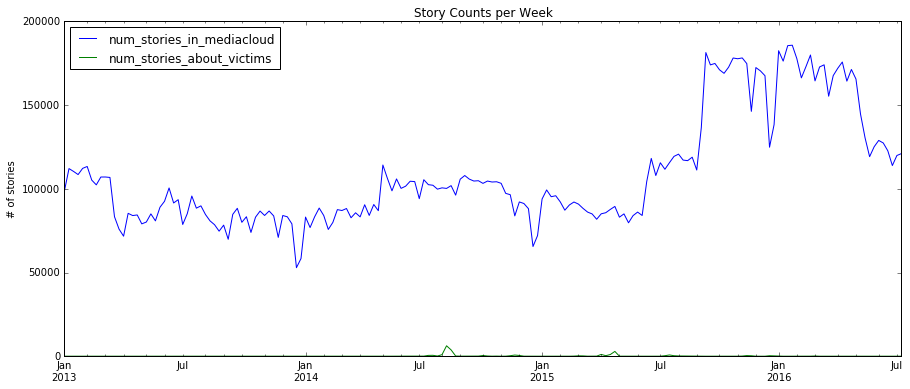

In [3]:
storycounts.plot(figsize=(15, 6))
plt.title('Story Counts per Week')
plt.ylabel('# of stories')
plt.savefig('storycountsperweek.png', bbox_inches='tight')

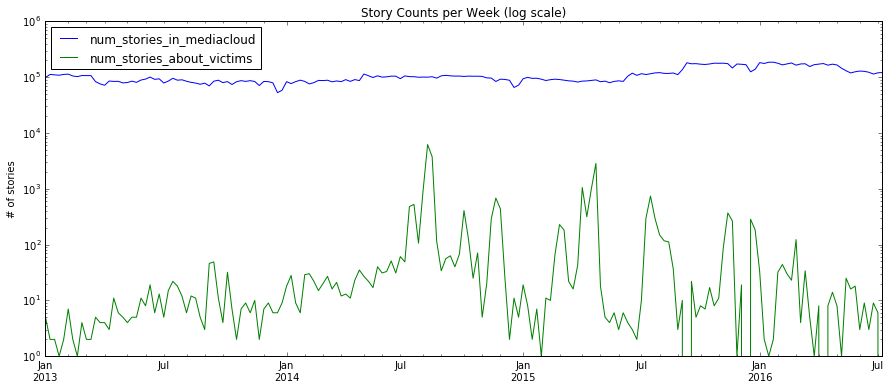

In [4]:
storycounts.plot(figsize=(15, 6), logy=True)
plt.title('Story Counts per Week (log scale)')
plt.ylabel('# of stories')
plt.savefig('storycountsperweek-log.png', bbox_inches='tight')

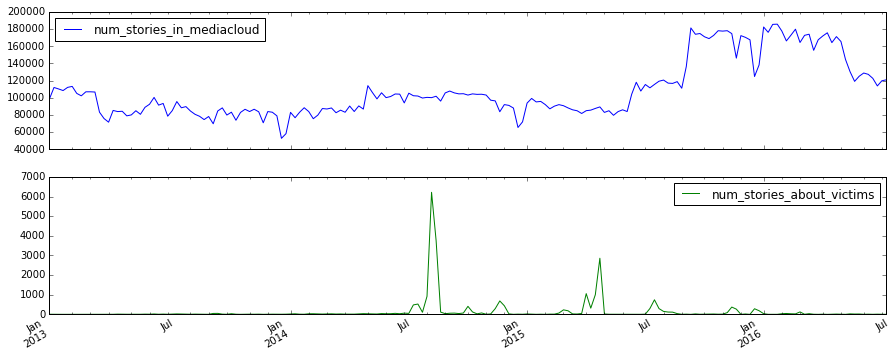

In [5]:
storycounts.plot(subplots=True, figsize=(15, 6))
plt.savefig('storycountsperweek-sep.png', bbox_inches='tight')

## incidents of "black lives matter" or "BLM" in the corpora

In [ ]:
day = datetime.date(2013,1,1)
week = datetime.timedelta(7)

dates = []
num_stories_with_BLM = []

while day < datetime.date(2016, 7, 13):
    # number of stories about victims of police violence in that week
    blm_stories = mc.storyCount('''({~ topic:1421} OR {~ topic:1326} OR {~ topic:1394} OR {~ topic:1408}) AND ("black lives matter" OR "blacklivesmatter")''', 
                                 solr_filter=[mc.publish_date_query( day, day+week )])
    num_stories_with_BLM.append(blm_stories['count'])
    
    # the first day of that week
    dates.append(day)
    
    # print progress and increment to next week
    print(day, blm_stories)
    day += week

In [ ]:
stories_about_blm = pd.DataFrame({'num_stories_about_BLM' : num_stories_with_BLM},
                                   index = dates)
stories_about_blm.to_csv(r'data\stories-about-blm.csv', encoding = 'utf-8')

## read from csv to you don't have the re-run the above

In [6]:
stories_about_blm = pd.read_csv(r'data\stories-about-blm.csv', index_col=0)
stories_about_blm.index = stories_about_blm.index.to_datetime()

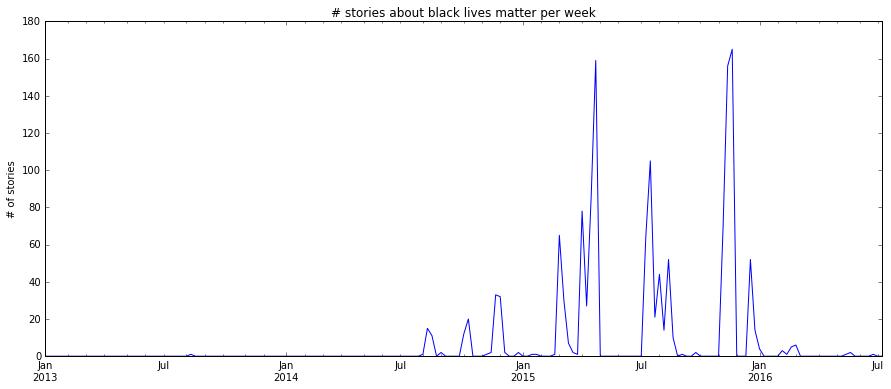

In [7]:
stories_about_blm['num_stories_about_BLM'].plot(figsize=(15, 6))
plt.title('# stories about black lives matter per week')
plt.ylabel('# of stories')
plt.savefig('numstoriesperweek-aboutBLM.png', bbox_inches='tight')

In [8]:
stories_about_blm['num_stories_about_victims'] = storycounts['num_stories_about_victims']
stories_about_blm['normalized_num_stories_about_blm'] = stories_about_blm['num_stories_about_BLM'] / stories_about_blm['num_stories_about_victims']

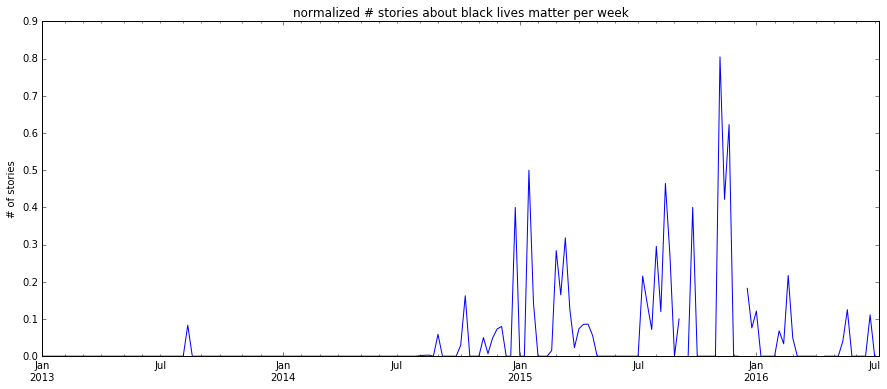

In [9]:
stories_about_blm['normalized_num_stories_about_blm'].plot(figsize=(15, 6))
plt.title('normalized # stories about black lives matter per week')
plt.ylabel('# of stories')
plt.savefig('normalizednumstoriesperweek-aboutBLM.png', bbox_inches='tight')

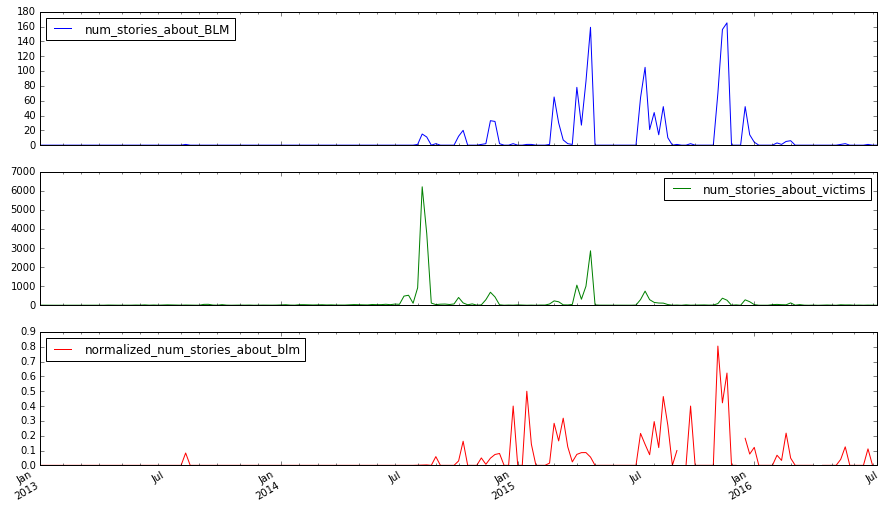

In [10]:
stories_about_blm.plot(subplots=True, figsize=(15, 9))
plt.savefig('summary-aboutBLM.png', bbox_inches='tight')

## in each story about a victim, how many references are there to prior victims?

In [16]:
# for each victim, build a big OR query of all prior victims
all_articles = pd.read_csv(r'data\article-dataset.csv', index_col=8)

desired_columns = ['query','date_of_death']

queries2013 = pd.read_csv(r'data\2013\mpv-total-story-counts.csv', index_col=0)[desired_columns]
queries2014 = pd.read_csv(r'data\2014\mpv-total-story-counts.csv', index_col=0)[desired_columns]
queries2015 = pd.read_csv(r'data\2015\mpv-total-story-counts.csv', index_col=0)[desired_columns]
queries2016 = pd.read_csv(r'data\2016\mpv-total-story-counts.csv', index_col=0)[desired_columns]
queries = pd.concat([queries2013, queries2014, queries2015, queries2016])
queries.sort_values('date_of_death', inplace=True)

In [17]:
story_ids = []
stories_about_person = []

query_of_all_prior_victims = []
stories_mentioning_prior_victims = []

for person in queries.index:
    
    # for each victim, build query of all prior victims, one by one
    
    priors = queries[queries['date_of_death'] < queries['date_of_death'][person]]
    query_of_priors = '(' + ' OR '.join(['(' + str(i) + ')' for i in priors['query']]) + ')'
    query_of_all_prior_victims.append(query_of_priors)

    # get list of all story_ids for each victim
    
    if person not in all_articles.index:
        stories_id_query = "(stories_id:())"
        story_ids.append(stories_id_query)
        
        stories_about_person.append(0)
        
    elif list(all_articles.index).count(person) == 1:
        stories_id_query = '(stories_id: (' + str(all_articles.loc[person]['stories_id']) + '))'
        story_ids.append(stories_id_query)
        
        stories_about_person.append(1)
        
    else:
        stories_id_query = ' '.join([str(i) for i in all_articles.loc[person]['stories_id']])
        stories_id_query = '(stories_id: (' + stories_id_query + '))'
        story_ids.append(stories_id_query)
        
        stories_about_person.append(len(all_articles.loc[person]['stories_id']))
        
    # query mediacloud for story counts about prior victims
    
    if stories_id_query == "(stories_id:())": # no stories
        stories_mentioning_prior_victims.append(0)
        
        print queries['date_of_death'][person], person, stories_about_person[-1], 0
        
    elif query_of_priors == '()': # no prior victims in this list        
        stories_mentioning_prior_victims.append(0)
        
        print queries['date_of_death'][person], person, stories_about_person[-1], 0
    
    else:         
        combinedquery = stories_id_query + ' AND ' + query_of_priors
        priorvictimsstorycount = mc.storyCount(combinedquery)
        
        stories_mentioning_prior_victims.append(priorvictimsstorycount['count'])
    
        print queries['date_of_death'][person], person, stories_about_person[-1], priorvictimsstorycount['count']
        
queries['story_ids'] = story_ids
queries['query_of_all_prior_victims'] = query_of_all_prior_victims
queries['stories_about_person'] = stories_about_person
queries['stories_mentioning_prior_victims'] = stories_mentioning_prior_victims

2013-01-04 Xavier Tyrell Johnson 2 0
2013-01-13 Quintine Barksdale 0 0
2013-01-17 Steven Askew 0 0
2013-01-19 Donovan Thomas 0 0
2013-01-28 Anthony Dwayne Harris 0 0
2013-02-13 Kayla Moore 0 0
2013-02-16 Charles A. Baker Jr. 0 0
2013-03-10 Clinton Roebexar Allen 1 0
2013-03-22 Russell Lydell Smith 0 0
2013-04-04 Jermaine C. Coleman Jr. 0 0
2013-04-06 Wilbur Frederick Miller II 0 0
2013-04-06 Clanesha Rayuna Shaqwanda Hickmon 0 0
2013-04-15 Dason Peters 6 0
2013-04-15 Dylan Samuel-Peters 6 0
2013-04-20 Craig Demps 0 0
2013-04-21 Fred Bradford Jr. 0 0
2013-05-22 Julian Dawkins 6 0
2013-07-09 Antonio Johnson 0 0
2013-07-16 Daryll Blair 0 0
2013-07-18 Tyrone West 0 0
2013-07-21 Deomain Hayman 0 0
2013-07-22 Kyam Livingston 5 0
2013-07-23 Jason M. Nalls 1 0
2013-07-25 Dainell Simmons 2 0
2013-07-26 Larry Eugene Jackson Jr. 1 0
2013-07-28 Ryan L. Stokes 0 0
2013-07-30 Allen Desdunes 0 0
2013-07-31 Jermaine McBean 1 0
2013-08-08 Montrell Moss 0 0
2013-08-08 Jeffery B. Lilly Jr. 0 0
2013-08-15

In [18]:
queries['normalized_stories_mentioning_prior_victims'] = queries['stories_mentioning_prior_victims'] / queries['stories_about_person']
queries.to_csv(r'data\mentions-of-prior-incidents.csv', encoding = 'utf-8')


## read from csv so you don't have to rerun the query

In [3]:
queries = pd.read_csv(r'data\mentions-of-prior-incidents.csv', index_col=0)
queries['date_of_death'] = pd.to_datetime(queries['date_of_death'])

C:\Users\Allan\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


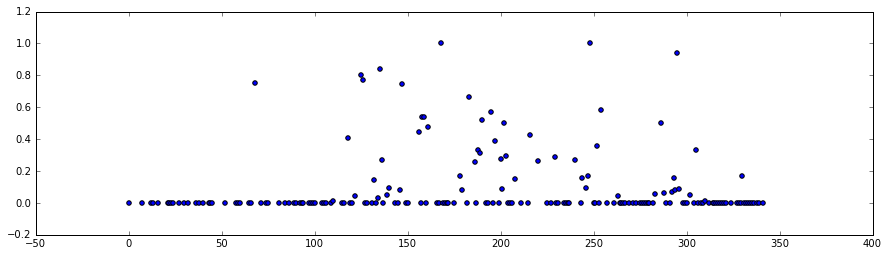

In [4]:
toplot = queries[['date_of_death', 'stories_about_person', 'stories_mentioning_prior_victims', 'normalized_stories_mentioning_prior_victims']]
toplot['index'] = range(len(queries['query']))

fig = plt.figure(figsize=(15,4))
plt.scatter(list(toplot['index']), list(toplot['normalized_stories_mentioning_prior_victims']))

In [5]:
def nameplot(series, namelist, colors = 'black', title = None, xlabel = None, ylabel = None, 
             plot_height = 450, plot_width=900, yaxistype = 'linear'):
    '''takes a pandas Series, indexed by qb name, generates color-coded plot of those series
    with names on the x-axis and values on the y-axis.
    returns a Bokeh plot.'''

    plot = figure(x_range = namelist, title = title,
                          plot_height = plot_height, plot_width = plot_width, tools = "save, box_zoom, xpan, reset",
                          y_axis_type = yaxistype)

    plot.circle(series.index.values, series, 
                        size=5, fill_color=colors, line_color=None)
    plot.xaxis.axis_label = xlabel
    plot.xaxis.major_label_orientation = np.pi/2
    plot.yaxis.axis_label = ylabel
    
    return plot

mentionsofpriors = nameplot(toplot['normalized_stories_mentioning_prior_victims'], 
                            list(toplot.index.values),
                            title = 'Fraction of stories mentioning prior victims')

storiesaboutperson = nameplot(toplot['stories_about_person'],
                              mentionsofpriors.x_range,
                              title = 'Total # stories about person',
                              xlabel = 'Victim',
                              plot_height = 200,
                              yaxistype = 'log',
                              colors = 'blue')
storiesaboutperson.xaxis.visible = False
output_file('stories_about_prior_victims.html')
show(gridplot([storiesaboutperson],[mentionsofpriors]))

In [11]:
queries.loc['Treon "Tree" Johnson']

query                                          (Treon AND Johnson OR "Tre Johnson" OR "Tree J...
date_of_death                                                                2014-02-27 00:00:00
story_ids                                      (stories_id: (208469092 208494849 490627450 28...
query_of_all_prior_victims                     ((("Xavier Tyrell Johnson" OR "Xavier T Johnso...
stories_about_person                                                                           4
stories_mentioning_prior_victims                                                               3
normalized_stories_mentioning_prior_victims                                                 0.75
Name: Treon "Tree" Johnson, dtype: object